In [395]:
%store -r Final_Data_Set_Nor

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter

[0.40050251 0.39497487 0.38442211 0.37286432 0.3638191 ]


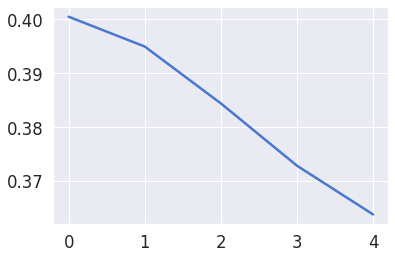

In [396]:
sector_rev = np.array([0.,0.,0.,0.,0.])
n = 0
for i in Final_Data_Set_Nor.items():
    ID, data = i
    if data['Sector'][1:-1] == "325412":
        sector_rev += np.array(data['Revenue'])
        n += 1
        
sector_rev = sector_rev/n
print(sector_rev)
plt.plot(range(len(sector_rev)),sector_rev)
plt.show()

In [397]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers)
    b_s_dst = T.tensor(b_s_dst)
    
    
    data_dict = {
    ('R&E', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE&TDE', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Description', 'text', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('E', 'E_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE', 'NDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('TDE', 'TDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Att_Description', 'text_att', 'Description' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('sector', 'belongs to', 'borrower'): (b_s_dst, b_s_src),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,2]), T.tensor([0,1,2]))
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Final_Data_Set_Nor)


In [398]:
def Loss_Function(embeddings, target_centers, centers):
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.sqrt(T.sum((embeddings - next_target)**2,1))
    a = T.sqrt(T.sum((embeddings - target_centers)**2,1))
    
#     a = a/T.max(a)
#     b = b/T.max(b)
    
#     print("a ", T.sum(a))
#     print("b ", T.sum(b),'\n')
    
    return T.sum((a))            #T.sum((-b))                #/T.max(T.sum(a),T.sum(b))
    

In [399]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_sector, out_sector, 'mean', norm = None, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_RE, out_RE, 'mean', norm = None, activation = None, bias = False) for rel in L2_names}, aggregate='sum')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_NT, out_NT, 'mean', norm = None, activation = None, bias = False) for rel in L3_names}, aggregate='sum')
        self.conv4 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_Des, out_Des, 'mean', norm = None, activation = None, bias = False) for rel in L4_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower, 'none', activation = None, bias = False) for rel in L5_names}, aggregate='sum')

    def forward(self, graph, inputs):
        sector_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['borrower']}
        h_sector = self.conv1(graph, sector_inputs)
        h_sector = {k: F.leaky_relu(v) for k, v in h_sector.items()}
        #print("Sector Shape ", h_sector['sector'].size())
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R&E Shape ", h_RE['R&E'].size())
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        h_NT = {k: F.leaky_relu(v) for k, v in h_NT.items()}
        #print("NDE&TDE Shape ", h_NT['NDE&TDE'].size())
        
        Des_inputs = {'Description' : inputs['Description'], 'Att_Description' : inputs['Att_Description'], 'borrower' : inputs['dummy_borrower']}
        h_Des = self.conv4(graph, Des_inputs)
        h_Des = {k: F.leaky_relu(v) for k, v in h_Des.items()}
        #print("Description Shape ", h_Des['Description'].size())
        
        borrower_inputs = {'sector' : h_sector['sector'], 'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E'], 'NDE&TDE' : h_NT['NDE&TDE'], 'Description' : h_Des['Description']}
        h_borrower = self.conv5(graph, borrower_inputs)
        
        return h_borrower
    


In [400]:
model = RGCN(5,5,5,5,768,5,5,5,5,5, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])


for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = [data['Revenue']]
    E_Att = [data['EBITDA']]
    NDE_Att = [data['NDE']]
    TDE_Att = [data['TDE']]
    Des_Att = data['Description Embedding']
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((T.tensor([data['Revenue']]),T.tensor(R_Att)),0)
    E_Att = T.cat((T.tensor([data['EBITDA']]),T.tensor(E_Att)),0)
    NDE_Att = T.cat((T.tensor([data['NDE']]),T.tensor(NDE_Att)),0)
    TDE_Att = T.cat((T.tensor([data['TDE']]),T.tensor(TDE_Att)),0)
    Des_Att = T.cat((T.tensor(data['Description Embedding']),T.tensor(Des_Att)),0)
    

G.nodes['borrower'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.zeros(n_borrowers,5)
G.nodes['Att_Description'].data['f'] = Des_Att[1:]
G.nodes['Description'].data['f'] = T.zeros(n_borrowers,768)
G.nodes['Factor'].data['f'] = T.zeros(n_sectors,5)
G.nodes['sector'].data['f'] = T.zeros(n_sectors,5)

/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

Avg Node Cluster Distance of Cluster  0  is  5.4895334
Cluster  0  Center  [ 1.1334614 -1.7368478]
Avg Node Cluster Distance of Cluster  1  is  2.675132
Cluster  1  Center  [10.936695 10.351749]
Avg Node Cluster Distance of Cluster  2  is  2.8153687
Cluster  2  Center  [-9.112661  -1.8106923]
Cluster Distance between  0  and others 
1   15.563983
2   10.246388
Cluster Distance between  1  and others 
0   15.563983
2   23.449982
Cluster Distance between  2  and others 
0   10.246388
1   23.449982


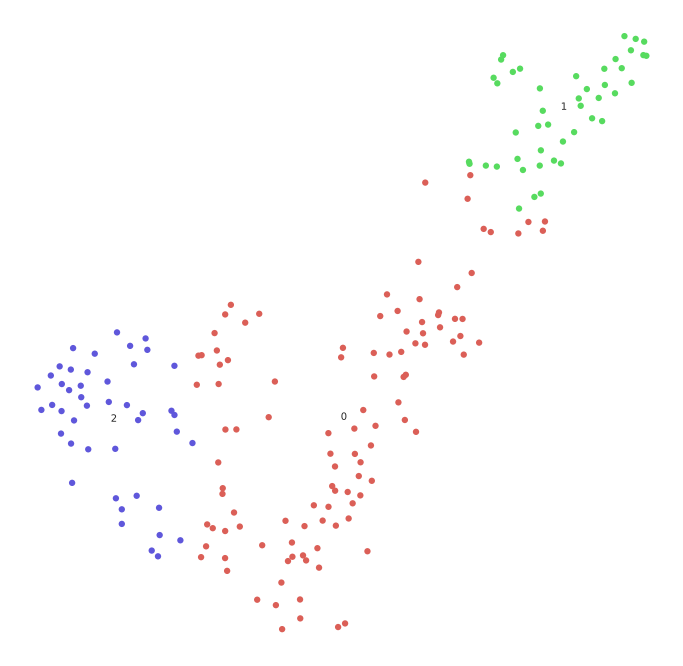

In [401]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
Des_feats = G.nodes['Description'].data['f']
Des_att_feats = G.nodes['Att_Description'].data['f']
factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.zeros(n_borrowers,768)

node_features = {'borrower':borrower_feats,'sector':sector_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'Description':Des_feats,'Att_Description':Des_att_feats,'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'Factor':factor_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 3
Loss = []
epochs = 100

for epoch in range(epochs):
    
    model.train()
    logits = model(G, node_features)
    
    X = logits['borrower'].detach().numpy()
    
    index = [i for i, n in enumerate(sector_list) if n == 0]
    X = X[index]
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    centers = kmeans.cluster_centers_
    
    target_centers = []
    for i in X:
        l = []
        for j in centers:
            mse = np.square(i - j).mean()
            l.append(mse)
        
        target_centers.append(l.index(min(l)))
        
        
    centers = T.tensor(centers)
    target_centers = centers[T.tensor(target_centers)]
    
    if epoch == 0:
        fashion_tsne = TSNE(random_state=123).fit_transform(X)
        fashion_scatter(fashion_tsne, kmeans.labels_)
        
    #loss = F.mse_loss(logits['borrower'], target_centers)
    score = Loss_Function(logits['borrower'][index], target_centers, centers)
    Loss.append(score.tolist())

    
    opt.zero_grad()
    score.backward()
    opt.step()



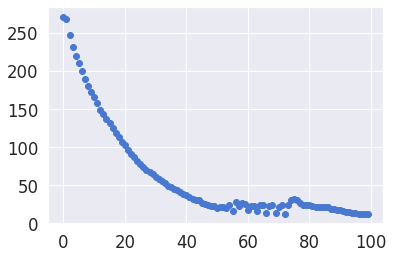

Avg Node Cluster Distance of Cluster  0  is  3.087178
Cluster  0  Center  [  5.096902 -14.508381]
Avg Node Cluster Distance of Cluster  1  is  2.7085574
Cluster  1  Center  [19.816523 14.016384]
Avg Node Cluster Distance of Cluster  2  is  1.8461974
Cluster  2  Center  [-19.402802    4.7429385]
Cluster Distance between  0  and others 
1   32.098747
2   31.158445
Cluster Distance between  1  and others 
0   32.098747
2   40.30077
Cluster Distance between  2  and others 
0   31.158445
1   40.30077


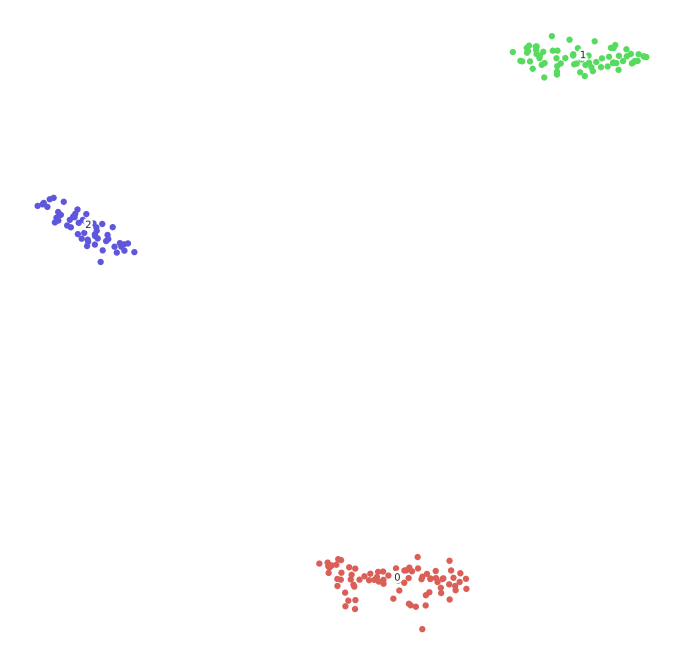

In [402]:
plt.scatter(list(range(len(Loss))),Loss)
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X)
fashion_scatter(fashion_tsne, kmeans.labels_)

79 68 52


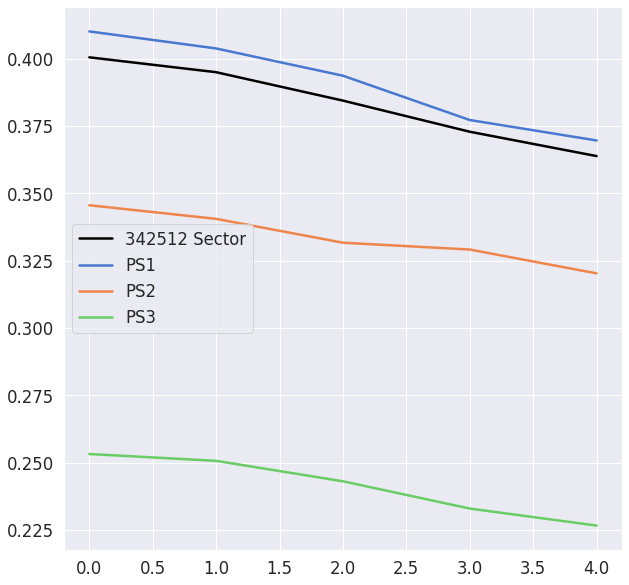

In [415]:
PS1 = []
PS2 = []
PS3 = []

for i in list(zip(index,kmeans.labels_)):
    ind,ps = i
    if ps == 0:
        PS1.append(ind)
    elif ps == 1:
        PS2.append(ind)
    elif ps == 2:
        PS3.append(ind)
        
Psector1_rev = np.array([0.,0.,0.,0.,0.])
Psector2_rev = np.array([0.,0.,0.,0.,0.])
Psector3_rev = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev += np.array(data['Revenue'])
        m += 1
    if n in PS2:
        Psector2_rev += np.array(data['Revenue'])
        p += 1
    if n in PS3:
        Psector3_rev += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev = Psector1_rev/m
Psector2_rev = Psector2_rev/m
Psector3_rev = Psector3_rev/m
plt.figure(figsize = (10,10))
plt.plot(range(len(sector_rev)),sector_rev,'k')
plt.plot(range(len(Psector1_rev)),Psector1_rev)
plt.plot(range(len(Psector2_rev)),Psector2_rev)
plt.plot(range(len(Psector3_rev)),Psector3_rev)
plt.legend(['342512 Sector', 'PS1', 'PS2', 'PS3'])
plt.show()

In [174]:
g = dgl.heterograph({
    ('user', 'follows', 'user') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('user', 'plays', 'game') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('store', 'sells', 'game')  : (T.tensor([0,1,2]),T.tensor([0,1,2]))})

In [189]:
import dgl.nn.pytorch as dglnn
conv = dglnn.HeteroGraphConv({
    'follows' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'plays' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'sells' : dglnn.SAGEConv(3,3, 'mean', norm = None,weight = False, activation = None, bias = False)}, aggregate='sum')

In [191]:
h1 = {'user' : T.rand(g.number_of_nodes('user'), 3), 'game' : T.ones(g.number_of_nodes('game'), 3)}
h11 = {'store' : T.rand(g.number_of_nodes('store'),3), 'game' : T.zeros(g.number_of_nodes('game'), 3)}
print(h1)
h2 = conv(g, h1)
print(h2)

{'user': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]]), 'game': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])}
{'game': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]]), 'user': tensor([[0.2381, 0.8439, 0.3931],
        [0.3619, 0.0391, 0.8795],
        [0.1815, 0.5393, 0.1728]])}
